# init

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import Spanve

(6471, 33)


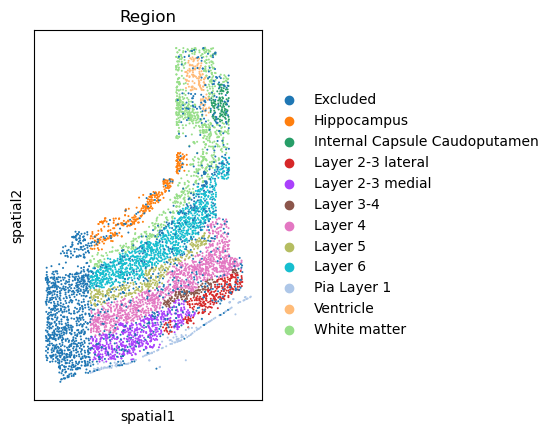

In [2]:
adata = sc.read_h5ad('./data/ACHIEVED/osmFISH_SScortex_mouse_all_cells.h5ad')
print(
    adata.X.shape,
)
adata_pre = Spanve.adata_preprocess(adata)

sc.pl.spatial(
    adata,spot_size=300,
    color='Region',
    save='mouse_cortext'
)

# SV usage

/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/Spanve/__init__.py:228: UserWarning: 
            WARNNING: X must be an int matrix; 
            ----------------------------------------
            Will automatically convert to int. Inputs can be Raw Counts or use `adata_preprocess_int` to get a normalized data with int dtype. 
  warnings.warn("""
/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/Spanve/__init__.py:385: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self.adata.var['spanve_spatial_features'] = result_df['rejects']


ARI:0.2833437616493765	AMI:0.3787985192898336


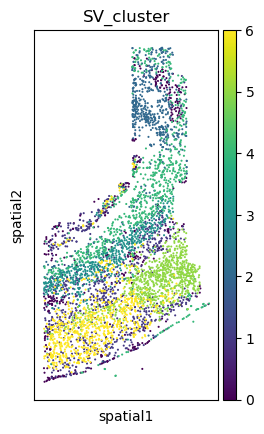

In [3]:
model = Spanve.Spanve(adata[adata_pre.obs_names,:])
model.fit()
X = adata_pre.X
newX = model.impute_from_graph(X)
label = Spanve.AutoCluster().fit_predict(newX)

valid_idx = adata_pre.obs_vector('Region') != 'Excluded' 
s1 = sklearn.metrics.adjusted_rand_score(adata_pre.obs_vector('Region')[valid_idx],label[valid_idx])
s2 = sklearn.metrics.adjusted_mutual_info_score(adata_pre.obs_vector('Region')[valid_idx],label[valid_idx])
print(f"ARI:{s1}\tAMI:{s2}")

adata_pre.obs['SV_cluster'] = label
sc.pl.spatial(
    adata_pre[valid_idx,:],spot_size=300,
    color='SV_cluster',
    save='SV_cluster'
)

# co-exp SV 

/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/Spanve/__init__.py:228: UserWarning: 
            WARNNING: X must be an int matrix; 
            ----------------------------------------
            Will automatically convert to int. Inputs can be Raw Counts or use `adata_preprocess_int` to get a normalized data with int dtype. 
  warnings.warn("""


ARI:0.3338756895879345	AMI:0.45443828054417423


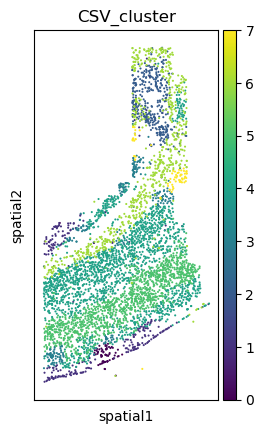

In [4]:
model = Spanve.Spanve(adata_pre)
from itertools import combinations
search_space = list(combinations(adata.var_names,2))
model.spatial_coexp(search_space)
model.fit(verbose=False)
newXco = model.impute_from_graph(model.adata.X)
label_co = Spanve.AutoCluster().fit_predict(newXco)

valid_idx = adata_pre.obs_vector('Region') != 'Excluded' 
s1 = sklearn.metrics.adjusted_rand_score(adata_pre.obs_vector('Region')[valid_idx],label_co[valid_idx])
s2 = sklearn.metrics.adjusted_mutual_info_score(adata_pre.obs_vector('Region')[valid_idx],label_co[valid_idx])
print(f"ARI:{s1}\tAMI:{s2}")

adata_pre.obs['CSV_cluster'] = label_co
sc.pl.spatial(
    adata_pre[valid_idx,:],spot_size=300,
    color='CSV_cluster',
    save='CSV_cluster'
)

ARI:0.34575371766822033	AMI:0.4664968159780878


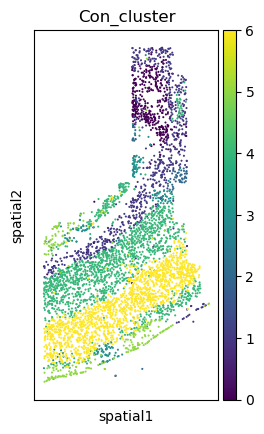

In [5]:
X_con = np.concatenate([newX,newXco],axis=1)
label_con = Spanve.AutoCluster().fit_predict(X_con)
valid_idx = adata_pre.obs_vector('Region') != 'Excluded' 
s1 = sklearn.metrics.adjusted_rand_score(adata_pre.obs_vector('Region')[valid_idx],label_con[valid_idx])
s2 = sklearn.metrics.adjusted_mutual_info_score(adata_pre.obs_vector('Region')[valid_idx],label_con[valid_idx])
print(f"ARI:{s1}\tAMI:{s2}")

adata_pre.obs['Con_cluster'] = label_con
sc.pl.spatial(
    adata_pre[valid_idx,:],spot_size=300,
    color='Con_cluster',
    save='CON_cluster'
)

In [11]:
for i in range(10):
    gene = model.result_df.sort_values(by='fdrs').index[i]
    sc.pl.spatial(
        model.adata,spot_size=300,
        color=gene,
        save=gene,cmap='coolwarm',show=False,vcenter=0
    )